In [86]:
#import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import missingno
import pylab
import scipy.stats as stats
import feature_engine
# Pretty display for notebooks
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
import re
from feature_engine import missing_data_imputers as msi
from feature_engine import variable_transformers as vt
from feature_engine import outlier_removers as outr

In [87]:
train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

In [88]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [89]:
#Combine test and train into one file
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test], ignore_index=True)
print(train.shape, test.shape, data.shape)

(95662, 17) (45019, 16) (140681, 17)


C:\Users\mo.yosiwealth\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [91]:
data.head()

,AccountId,Amount,BatchId,ChannelId,CountryCode,CurrencyCode,CustomerId,FraudResult,PricingStrategy,ProductCategory,ProductId,ProviderId,SubscriptionId,TransactionId,TransactionStartTime,Value,source
0,AccountId_3957,1000.0,BatchId_36123,ChannelId_3,256,UGX,CustomerId_4406,0.0,2,airtime,ProductId_10,ProviderId_6,SubscriptionId_887,TransactionId_76871,2018-11-15T02:18:49Z,1000,train
1,AccountId_4841,-20.0,BatchId_15642,ChannelId_2,256,UGX,CustomerId_4406,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_73770,2018-11-15T02:19:08Z,20,train
2,AccountId_4229,500.0,BatchId_53941,ChannelId_3,256,UGX,CustomerId_4683,0.0,2,airtime,ProductId_1,ProviderId_6,SubscriptionId_222,TransactionId_26203,2018-11-15T02:44:21Z,500,train
3,AccountId_648,20000.0,BatchId_102363,ChannelId_3,256,UGX,CustomerId_988,0.0,2,utility_bill,ProductId_21,ProviderId_1,SubscriptionId_2185,TransactionId_380,2018-11-15T03:32:55Z,21800,train
4,AccountId_4841,-644.0,BatchId_38780,ChannelId_2,256,UGX,CustomerId_988,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_28195,2018-11-15T03:34:21Z,644,train


In [93]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

In [102]:
#Drop the columns
data.drop(['AccountId', 'Amount','BatchId','CountryCode','CurrencyCode','CustomerId',
           'SubscriptionId','TransactionId'],axis=1,inplace=True)

In [104]:
data.head()

,ChannelId,FraudResult,PricingStrategy,ProductCategory,ProductId,ProviderId,TransactionStartTime,Value,source
0,ChannelId_3,0.0,2,airtime,ProductId_10,ProviderId_6,2018-11-15T02:18:49Z,1000,train
1,ChannelId_2,0.0,2,financial_services,ProductId_6,ProviderId_4,2018-11-15T02:19:08Z,20,train
2,ChannelId_3,0.0,2,airtime,ProductId_1,ProviderId_6,2018-11-15T02:44:21Z,500,train
3,ChannelId_3,0.0,2,utility_bill,ProductId_21,ProviderId_1,2018-11-15T03:32:55Z,21800,train
4,ChannelId_2,0.0,2,financial_services,ProductId_6,ProviderId_4,2018-11-15T03:34:21Z,644,train


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140681 entries, 0 to 140680
Data columns (total 9 columns):
ChannelId               140681 non-null object
FraudResult             95662 non-null float64
PricingStrategy         140681 non-null int64
ProductCategory         140681 non-null object
ProductId               140681 non-null object
ProviderId              140681 non-null object
TransactionStartTime    140681 non-null object
Value                   140681 non-null int64
source                  140681 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 9.7+ MB


In [109]:
cat_vars = [var for var in data.columns if data[var].dtypes=='O']

print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  6


In [111]:
for var in cat_vars:
    print(var, len(data[var].unique()), ' categories')

ChannelId 5  categories
ProductCategory 10  categories
ProductId 27  categories
ProviderId 6  categories
TransactionStartTime 138574  categories
source 2  categories


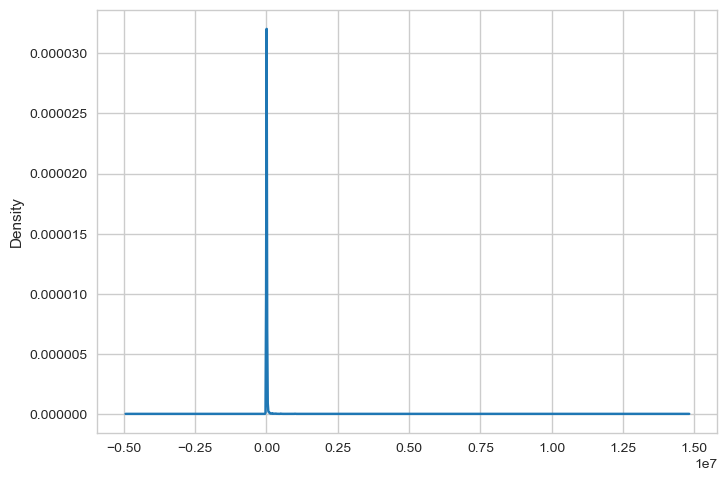

In [112]:
plt.figure()
data.Value.plot(kind="kde")
plt.show()

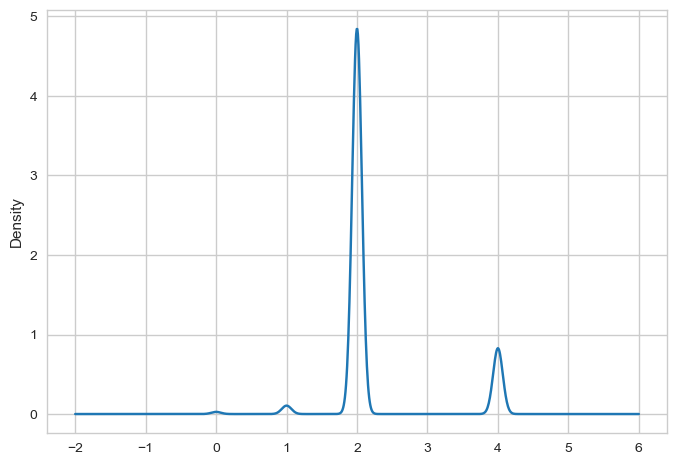

In [113]:
plt.figure()
data.PricingStrategy.plot(kind="kde")
plt.show()